# Imports #

In [35]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import random
import os

from sklearn.model_selection import train_test_split

# EDA #

In [5]:
train_df = pd.read_csv("./data/train_images.csv")
test_samples = pd.read_csv("./data/test_images_sample.csv")

class_names = np.load("data/class_names.npy", allow_pickle=True).item()

#print(train_labels.head())

for bird in list(class_names.keys()):
    print(bird)

001.Black_footed_Albatross
002.Laysan_Albatross
003.Sooty_Albatross
004.Groove_billed_Ani
005.Crested_Auklet
006.Least_Auklet
007.Parakeet_Auklet
008.Rhinoceros_Auklet
009.Brewer_Blackbird
010.Red_winged_Blackbird
011.Rusty_Blackbird
012.Yellow_headed_Blackbird
013.Bobolink
014.Indigo_Bunting
015.Lazuli_Bunting
016.Painted_Bunting
017.Cardinal
018.Spotted_Catbird
019.Gray_Catbird
020.Yellow_breasted_Chat
021.Eastern_Towhee
022.Chuck_will_Widow
023.Brandt_Cormorant
024.Red_faced_Cormorant
025.Pelagic_Cormorant
026.Bronzed_Cowbird
027.Shiny_Cowbird
028.Brown_Creeper
029.American_Crow
030.Fish_Crow
031.Black_billed_Cuckoo
032.Mangrove_Cuckoo
033.Yellow_billed_Cuckoo
034.Gray_crowned_Rosy_Finch
035.Purple_Finch
036.Northern_Flicker
037.Acadian_Flycatcher
038.Great_Crested_Flycatcher
039.Least_Flycatcher
040.Olive_sided_Flycatcher
041.Scissor_tailed_Flycatcher
042.Vermilion_Flycatcher
043.Yellow_bellied_Flycatcher
044.Frigatebird
045.Northern_Fulmar
046.Gadwall
047.American_Goldfinch
048.Eu

In [7]:
train_df.sample(20)

,image_path,label
1665,/train_images/1666.jpg,57
3375,/train_images/3376.jpg,142
2021,/train_images/2022.jpg,71
2481,/train_images/2482.jpg,91
1784,/train_images/1785.jpg,62
1296,/train_images/1297.jpg,44
936,/train_images/937.jpg,31
2357,/train_images/2358.jpg,85
2123,/train_images/2124.jpg,75
1982,/train_images/1983.jpg,69


In [9]:
print(train_df["label"].value_counts())

# Count of each class goes from 5 to 35
print("Min amount of times a class appears:", (train_df["label"].value_counts()).min())
print("Max amount of times a class appears:", (train_df["label"].value_counts()).max())

label
1      35
4      35
2      35
9      34
10     34
       ..
196     6
197     5
198     5
199     5
200     5
Name: count, Length: 200, dtype: int64
Min amount of times a class appears: 5
Max amount of times a class appears: 35


I decided to add a new column, `class_labels`, with the categorical name of each label so it was easier to visualise and have a better idea on which birds had the higher number of occurrences.

In [13]:
train_df['class_name'] = train_df['label'].map(
    {v: k for k, v in class_names.items()}  # Reverse the dictionary to map label to class_name
)

train_df['class_name'] = [
    "_".join(name.split('.')[1].split('_')) for name in train_df['class_name']
]

train_df['image_path'] = 'data' + train_df['image_path']
train_df

,image_path,label,class_name
0,data/train_images/1.jpg,1,Black_footed_Albatross
1,data/train_images/2.jpg,1,Black_footed_Albatross
2,data/train_images/3.jpg,1,Black_footed_Albatross
3,data/train_images/4.jpg,1,Black_footed_Albatross
4,data/train_images/5.jpg,1,Black_footed_Albatross
...,...,...,...
3921,data/train_images/3922.jpg,200,Common_Yellowthroat
3922,data/train_images/3923.jpg,200,Common_Yellowthroat
3923,data/train_images/3924.jpg,200,Common_Yellowthroat
3924,data/train_images/3925.jpg,200,Common_Yellowthroat


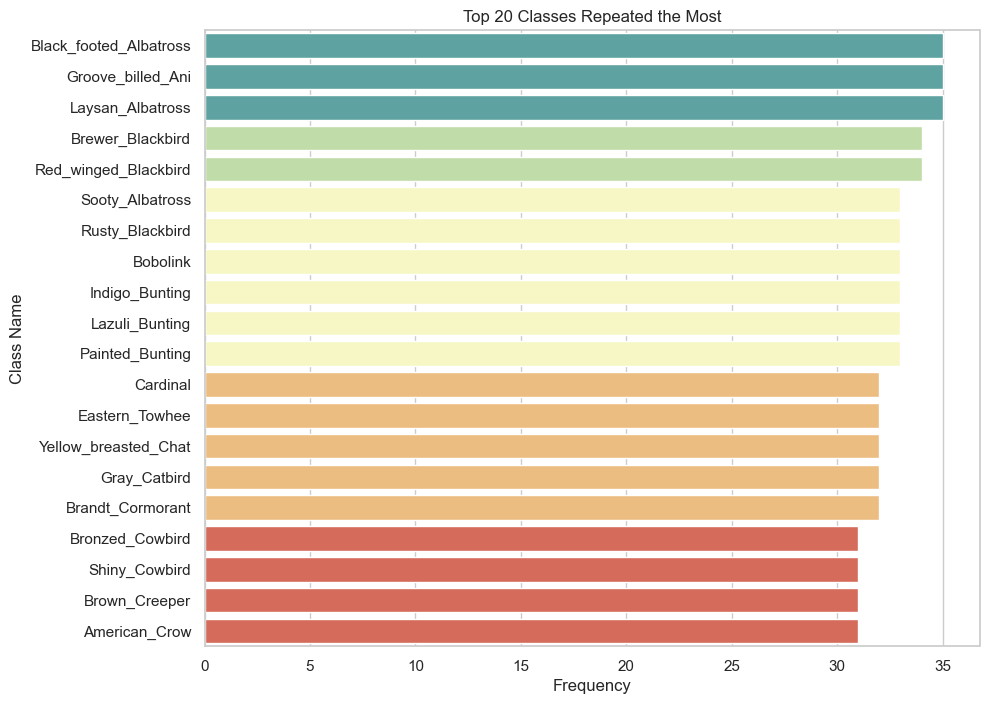

In [14]:
# Let's check beautifully which are the top 20 most repeated bird classes
top_20 = (train_df['class_name'].value_counts()[:20])

color_palette = sns.color_palette("Spectral", len(set(top_20.values)))
frequency_to_color = {freq: color for freq, color in zip(sorted(set(top_20.values)), color_palette)}
bar_colors = [frequency_to_color[freq] for freq in top_20.values]

sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
sns.barplot(
    x=top_20.values,
    y=top_20.index,
    palette=bar_colors
)
plt.xlabel("Frequency")
plt.ylabel("Class Name")
plt.title("Top 20 Classes Repeated the Most")
plt.show()

#### Sample of images available for training

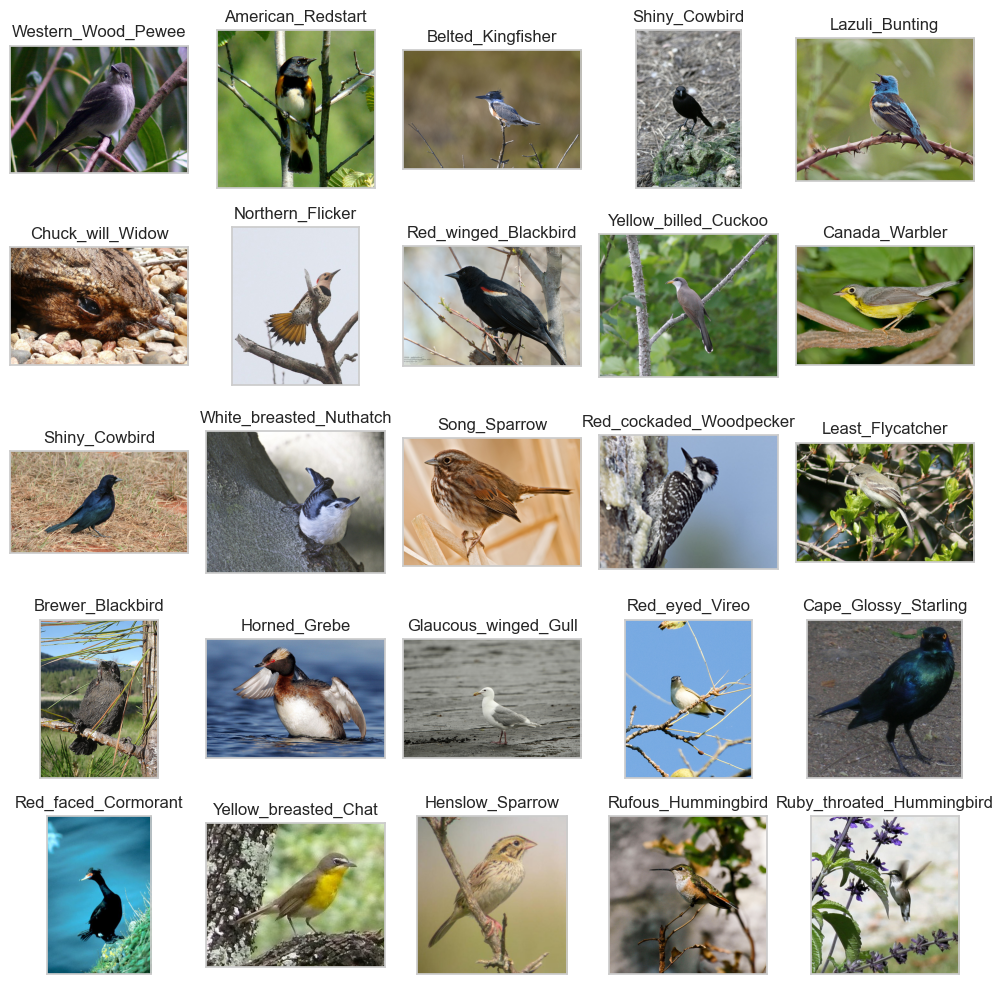

In [15]:
sample_df = train_df.sample(25)

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10), 
                         subplot_kw={'xticks': [], 'yticks': []})

for ax, (_, row) in zip(axes.flat, sample_df.iterrows()):
    ax.imshow(plt.imread(row['image_path']))
    ax.set_title(row['class_name'])

plt.tight_layout()
plt.show()

## Visualizations after Modelling and Data Processing

#### Visualization of Augmented images

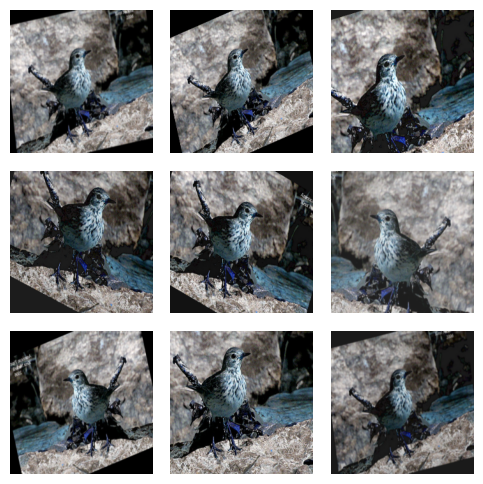

In [40]:
def custom_augment(image, image_size=224):
    
    if random.random() < 0.5:
        angle = random.uniform(-30, 30)
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        image = cv2.warpAffine(image, rotation_matrix, (w, h))
    
    if random.random() < 0.5:
        image = cv2.flip(image, 1)  # Horizontal flip
    
    if random.random() < 0.5:
        alpha = random.uniform(0.8, 1.2)
        beta = random.randint(-30, 30)
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    if random.random() < 0.5:
        h, w = image.shape[:2]
        crop_size = random.uniform(0.7, 1.0)
        crop_h, crop_w = int(h * crop_size), int(w * crop_size)
        start_x = random.randint(0, w - crop_w)
        start_y = random.randint(0, h - crop_h)
        image = image[start_y:start_y + crop_h, start_x:start_x + crop_w]
    
    if random.random() < 0.5:
        ksize = random.choice([3, 5])
        image = cv2.GaussianBlur(image, (ksize, ksize), 0)
    
    image = cv2.resize(image, (image_size, image_size))
    return image


def display_images(image, n_aug=9, image_size=224):
    augmented_images = []
    for _ in range(n_aug):
        augmented_image = custom_augment(image, image_size=image_size)
        augmented_images.append(augmented_image)
    return augmented_images


path = train_df.sample(1).iloc[0]['image_path']
og_image = cv2.imread(path.strip())

aug_images = display_images(og_image, n_aug=9)

plt.figure(figsize=(5, 5))
for i, img in enumerate(aug_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img.astype('uint8'))
    plt.axis("off")
plt.tight_layout()
plt.show()

In [39]:
grid_size = int(len(aug_images) ** 0.5)

h, w, c = aug_images[0].shape

ouput_image = np.zeros((grid_size * h, grid_size * w, c), dtype=np.uint8)

# Place each image into the grid
for idx, img in enumerate(aug_images):
    row = idx // grid_size
    col = idx % grid_size
    y_start, y_end = row * h, (row + 1) * h
    x_start, x_end = col * w, (col + 1) * w
    ouput_image[y_start:y_end, x_start:x_end, :] = img

cv2.imwrite("aug_image.jpg", cv2.cvtColor(ouput_image, cv2.COLOR_RGB2BGR))

True

#### Accuracy comparison graph

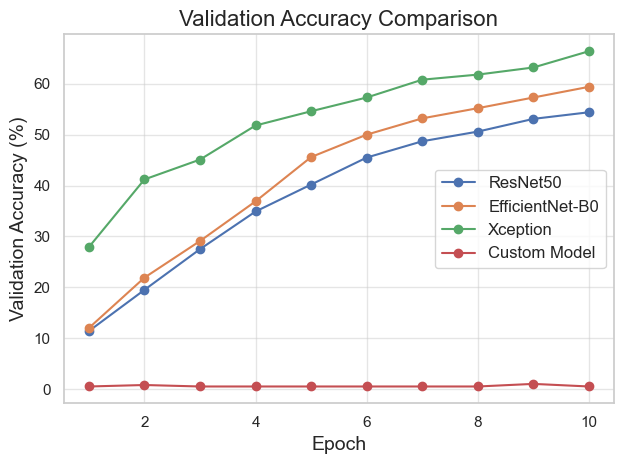

In [44]:
val_accuracies = {
    "ResNet50": [11.4, 19.5, 27.5, 34.9, 40.2, 45.5, 48.7, 50.6, 53.1, 54.4],
    "EfficientNet-B0": [12.0, 21.9, 29.1, 36.9, 45.6, 50.0, 53.2, 55.2, 57.3, 59.4],
    "Xception": [27.9, 41.2, 45.1, 51.8, 54.6, 57.3, 60.8, 61.8, 63.2, 66.4],
    "Custom Model": [0.51, 0.8, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 1.02, 0.51]
}

for model_name, acc in val_accuracies.items():
    epochs = list(range(1, len(acc) + 1)) 
    plt.plot(epochs, acc, marker='o', label=model_name)

plt.title("Validation Accuracy Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Validation Accuracy (%)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

### This is the part where we realised what we missed and why we got such Overfitting, sadly it was too late and everyone in the group was too tired to even try to run this

In [90]:
def custom_augment(dataframe, image_column="image_path", label_column="label"):
    images = []
    class_labels = []

    for image, class_label in zip(training_data, training_classes):

        images.append(image)

        # Horizontal flip
        flip = np.flip(image, axis=1)
        images.append(flip)
    
        # Rotate 15 degrees
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        rotate = cv2.getRotationMatrix2D(center, 15, 1.0)
        image_rotate = cv2.warpAffine(image, rotate, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        images.append(image_rotate)

        # Rotate -15 degrees
        m_rotate = cv2.getRotationMatrix2D(center, -30, 1.0)
        image_minus = cv2.warpAffine(image, m_rotate, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        images.append(image_minus)

        # Color Jitter
        alpha = random.uniform(0.8, 1.2)  
        beta = random.randint(-20, 20)  
        image_color = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
        images.append(image_color)
    
        # Random cropping
        crop_size = random.uniform(0.7, 0.9)
        crop_h, crop_w = int(h * crop_size), int(w * crop_size)
        start_x = random.randint(0, w - crop_w)
        start_y = random.randint(0, h - crop_h)
        cropped_image = image[start_y:start_y + crop_h, start_x:start_x + crop_w]
        cropped_image = cv2.resize(cropped_image, (224, 224))
        images.append(cropped_image)

        # extend labels as well
        class_labels.extend([class_label] * 6)  

    return images, class_labels

In [49]:
import cv2
import numpy as np
import random

def augment_images(dataframe, image_column="image_path", label_column="label"):

    augmented_images = []
    augmented_labels = []

    for _, row in dataframe.iterrows():
        img_path = row[image_column]
        label = row[label_column]

        # Load the image
        image = cv2.imread(img_path.strip())
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Original image
        augmented_images.append(image)
        augmented_labels.append(label)

        # Horizontal flip
        flipped_image = np.flip(image, axis=1)
        augmented_images.append(flipped_image)
        augmented_labels.append(label)

        # Rotate 15 degrees
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M_30 = cv2.getRotationMatrix2D(center, 15, 1.0)
        rotated_image_30 = cv2.warpAffine(image, M_30, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        augmented_images.append(rotated_image_30)
        augmented_labels.append(label)

        # Rotate -15 degrees
        M_minus_30 = cv2.getRotationMatrix2D(center, -15, 1.0)
        rotated_image_minus_30 = cv2.warpAffine(image, M_minus_30, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        augmented_images.append(rotated_image_minus_30)
        augmented_labels.append(label)

        # Color contrast and brightness
        alpha = random.uniform(0.8, 1.2) 
        beta = random.randint(-30, 30)
        adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
        augmented_images.append(adjusted_image)
        augmented_labels.append(label)

        # Random cropping
        crop_size = random.uniform(0.7, 0.9)
        crop_h, crop_w = int(h * crop_size), int(w * crop_size)
        start_x = random.randint(0, w - crop_w)
        start_y = random.randint(0, h - crop_h)
        cropped_image = image[start_y:start_y + crop_h, start_x:start_x + crop_w]
        cropped_image = cv2.resize(cropped_image, (224, 224))
        augmented_images.append(cropped_image)
        augmented_labels.append(label)

    return augmented_images, augmented_labels


In [62]:
train_data = pd.read_csv("./data/train_images.csv")
train_data['image_path'] = 'data' + train_data['image_path']

train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

print(f"Train: {len(train_df)}, Test: {len(test_df)}")

augmented_images, augmented_labels = augment_images(train_df, image_column="image_path", label_column="label")

Train: 3140, Test: 786


In [63]:
len(augmented_labels)

18840

In [81]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

class BirdieDataset(Dataset):
    def __init__(self, images, labels, transform=None, image_size=224):
        """
        Custom dataset for augmented images.

        Args:
            images (list): List of augmented images (NumPy arrays).
            labels (list): Corresponding labels for the images.
            transform (callable, optional): Transformations to apply to the images (e.g., normalization).
            image_size (int): Target size for resizing (default: 224).
        """
        assert len(images) == len(labels), "Images and labels must have the same length!"
        self.images = images
        self.labels = labels
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Resize the image to a consistent shape
        image = cv2.resize(image, (self.image_size, self.image_size))

        # Apply additional transforms
        if self.transform:
            image = Image.fromarray(image)  # Convert NumPy array to PIL Image
            image = self.transform(image)

        return image, label



# # Create the augmented dataset
# train_dataset = AugmentedDataset(augmented_images, augmented_labels, transform=train_transform)

# # Create the DataLoader
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Check the shape of batches
# for batch_idx, (images, labels) in enumerate(train_loader):
#     print(f"Batch {batch_idx}: Images shape {images.size()}, Labels shape {labels.size()}")



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalization for pretrained models
])


In [87]:
import os
import cv2
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Custom function to augment images
def augment_images(dataframe, image_column="image_path", label_column="label", image_size=224):
    """
    Augments images using custom transformations and returns augmented images and labels.

    Args:
        dataframe (pd.DataFrame): DataFrame containing image paths and labels.
        image_column (str): Column name for image paths (default: "image_path").
        label_column (str): Column name for labels (default: "label").
        image_size (int): Target size for resizing images (default: 224).

    Returns:
        tuple: A tuple containing the list of augmented images and their corresponding labels.
    """
    augmented_images = []
    augmented_labels = []

    for _, row in dataframe.iterrows():
        img_path = row[image_column]
        label = row[label_column]

        # Load the image
        image = cv2.imread(img_path.strip())
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize the original image
        image = cv2.resize(image, (image_size, image_size))
        augmented_images.append(image)
        augmented_labels.append(label)

        # Horizontal flip
        flipped_image = np.flip(image, axis=1)
        augmented_images.append(flipped_image)
        augmented_labels.append(label)

        # Rotate by 30 degrees
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M_30 = cv2.getRotationMatrix2D(center, 30, 1.0)
        rotated_image_30 = cv2.warpAffine(image, M_30, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        rotated_image_30 = cv2.resize(rotated_image_30, (image_size, image_size))
        augmented_images.append(rotated_image_30)
        augmented_labels.append(label)

        # Rotate by -30 degrees
        M_minus_30 = cv2.getRotationMatrix2D(center, -30, 1.0)
        rotated_image_minus_30 = cv2.warpAffine(image, M_minus_30, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        rotated_image_minus_30 = cv2.resize(rotated_image_minus_30, (image_size, image_size))
        augmented_images.append(rotated_image_minus_30)
        augmented_labels.append(label)

        # Random brightness and contrast adjustment
        alpha = random.uniform(0.8, 1.2)  # Contrast control
        beta = random.randint(-30, 30)    # Brightness control
        adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
        adjusted_image = cv2.resize(adjusted_image, (image_size, image_size))
        augmented_images.append(adjusted_image)
        augmented_labels.append(label)

        # Gaussian blur
        ksize = random.choice([3, 5])  # Kernel size
        blurred_image = cv2.GaussianBlur(image, (ksize, ksize), 0)
        blurred_image = cv2.resize(blurred_image, (image_size, image_size))
        augmented_images.append(blurred_image)
        augmented_labels.append(label)

    return augmented_images, augmented_labels


# Custom Dataset class
class BirdieDataset(Dataset):
    def __init__(self, images, labels, transform=None, image_size=224):
        """
        Custom dataset for both augmented and non-augmented data.

        Args:
            images (list or pd.Series): List of image arrays or image paths.
            labels (list or pd.Series): Corresponding labels.
            transform (callable, optional): Transformations to apply.
            image_size (int): Target size for resizing (default: 224).
        """
        assert len(images) == len(labels), "Images and labels must have the same length!"
        self.images = images
        self.labels = labels
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # If images are paths, load and preprocess them
        if isinstance(image, str):
            image = cv2.imread(image.strip())
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))

        # Apply transformations
        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)

        return image, label


# Define transformations
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = pd.read_csv("./data/train_images.csv")
train_data['image_path'] = 'data' + train_data['image_path']

train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

# Augment training data
augmented_images, augmented_labels = augment_images(train_df)

# Create datasets
train_dataset = BirdieDataset(augmented_images, augmented_labels, transform=train_transform)
val_dataset = BirdieDataset(val_df["image_path"].tolist(), val_df["label"].tolist(), transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(set(augmented_labels))) 

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define the validation function
def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100.0 * correct / total


num_epochs = 10
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training phase
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    val_accuracy = evaluate_model(model, val_loader, device)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

print(f"Training complete. Best Validation Accuracy: {best_val_accuracy:.2f}%")


IndexError: Target 200 is out of bounds.